# Training Dataset Preparation

## 1. Setup and Paths

In [1]:
# --- Imports ---

import os
import random
from pathlib import Path
import json
import re
import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import unicodedata

# --- Random seed ---
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

print("SEED =", SEED)


SEED = 42


In [2]:
PROJECT_ROOT = Path("/Users/eugenia/Desktop/thesis/magic_tagger")

INDEX_DIR = PROJECT_ROOT / "data" / "index"
TEXT_DIR = PROJECT_ROOT / "data" / "processed" / "text_extraction"
XML_ROOT = PROJECT_ROOT / "data" / "raw" / "transcriptions_local"
FIG_DIR = PROJECT_ROOT / "notebooks" / "figures"
xlsx_path = INDEX_DIR / "corpus_b_v1_20251230.xlsx"

## 2. Load Source Tables

In [3]:
df = pd.read_excel(xlsx_path)

print("Shape:", df.shape)
print("\nColumns:")
print(list(df.columns))

display(df.head())

print("\nDtypes:")
print(df.dtypes)

Shape: (61, 40)

Columns:
['tale_id', 'collection', 'volume_no', 'source_ref', 'digital_carrier', 'rights_status', 'narrator', 'collector_1', 'collector_2', 'collector_3', 'collector_4', 'collector_5', 'narrator_school', 'recording_parish', 'recording_place', 'narrator_origin_parish', 'narrator_origin_place', 'recorded_date_start', 'recorded_date_end', 'content_description', 'genre_1', 'genre_2', 'genre_3', 'subgenre', 'folklore_category', 'local_type_scheme', 'local_type', 'type_code_1', 'type_code_2', 'type_code_3', 'type_code_4', 'mapping_status', 'mapping_relation', 'mapping_date', 'mapping_by', 'gold_status', 'type_count', 'set', 'sampling_version', 'coverage_rate']


,tale_id,collection,volume_no,source_ref,digital_carrier,rights_status,narrator,collector_1,collector_2,collector_3,...,type_code_4,mapping_status,mapping_relation,mapping_date,mapping_by,gold_status,type_count,set,sampling_version,coverage_rate
0,era_vene_2_161_14,"ERA, Vene",2,"ERA, Vene 2, 161/5 (14)",scan_only,open,Nimi: Ан. Мухина,Koniaev Fedor,NaN,NaN,...,NaN,not_needed_native_atu,exact,20.12.2025,Evgeniia Vdovichenko,ok,6,core,v1_20251230,0.15
1,era_vene_2_622_5,"ERA, Vene",2,"ERA, Vene 2, 622/6 (5)",scan_only,open,Nimi: Денисиха,Koniaev Fedor,NaN,NaN,...,NaN,not_needed_native_atu,exact,20.12.2025,Evgeniia Vdovichenko,ok,2,core,v1_20251230,0.15
2,era_vene_2_748_27,"ERA, Vene",2,"ERA, Vene 2, 748/9 (27)",scan_only,open,Nimi: Нина Мухина,Koniaev Fedor,NaN,NaN,...,NaN,not_needed_native_atu,exact,20.12.2025,Evgeniia Vdovichenko,ok,3,core,v1_20251230,0.15
3,era_vene_4_367_1,"ERA, Vene",4,"ERA, Vene 4, 367/402 (1)",scan_only,open,"Nimi: Дария Липина, Vanus/Sünniaasta: 1851",Dondukova Zoya,NaN,NaN,...,NaN,not_needed_native_atu,exact,20.12.2025,Evgeniia Vdovichenko,ok,4,core,v1_20251230,0.15
4,era_vene_4_403_2,"ERA, Vene",4,"ERA, Vene 4, 403/29 (2)",scan_only,open,"Nimi: Дария Липина, Vanus/Sünniaasta: 1851",Dondukova Zoya,NaN,NaN,...,NaN,not_needed_native_atu,exact,20.12.2025,Evgeniia Vdovichenko,ok,6,core,v1_20251230,0.15



Dtypes:
tale_id                    object
collection                 object
volume_no                   int64
source_ref                 object
digital_carrier            object
rights_status              object
narrator                   object
collector_1                object
collector_2                object
collector_3                object
collector_4                object
collector_5                object
narrator_school            object
recording_parish           object
recording_place            object
narrator_origin_parish     object
narrator_origin_place      object
recorded_date_start        object
recorded_date_end          object
content_description        object
genre_1                    object
genre_2                    object
genre_3                   float64
subgenre                   object
folklore_category          object
local_type_scheme          object
local_type                 object
type_code_1                object
type_code_2                object
type_

In [4]:

type_code_cols = sorted(
    [c for c in df.columns if re.fullmatch(r"type_code_\d+", str(c))],
    key=lambda x: int(x.split("_")[-1])
)

print("Detected type_code columns:", type_code_cols)

Detected type_code columns: ['type_code_1', 'type_code_2', 'type_code_3', 'type_code_4']


In [5]:

base_cols = [
    "tale_id",
    "collection",
    "volume_no",
    "source_ref",
    "rights_status",
    "content_description",
    "set",
    "sampling_version",
    'type_count'
]
keep_cols = [c for c in base_cols if c in df.columns] + type_code_cols
df_train_index = df[keep_cols].copy()

def row_to_labels(row, cols):
    labels = []
    for c in cols:
        v = row.get(c)
        if pd.isna(v):
            continue
        v = str(v).strip()
        if not v:
            continue
        labels.append(v)
    
    seen = set()
    uniq = []
    for x in labels:
        if x not in seen:
            uniq.append(x)
            seen.add(x)
    return uniq

df_train_index["atu_labels"] = df_train_index.apply(lambda r: row_to_labels(r, type_code_cols), axis=1)

df_train_index["atu_labels_json"] = df_train_index["atu_labels"].apply(lambda x: json.dumps(x, ensure_ascii=False))

df_train_index_no_codes = df_train_index.drop(columns=type_code_cols)

print("Result shape:", df_train_index_no_codes.shape)
display(df_train_index_no_codes.head())

Result shape: (61, 11)


,tale_id,collection,volume_no,source_ref,rights_status,content_description,set,sampling_version,type_count,atu_labels,atu_labels_json
0,era_vene_2_161_14,"ERA, Vene",2,"ERA, Vene 2, 161/5 (14)",open,Сказка про царей.,core,v1_20251230,6,[707],"[""707""]"
1,era_vene_2_622_5,"ERA, Vene",2,"ERA, Vene 2, 622/6 (5)",open,Сказка об аленьком цветочке.,core,v1_20251230,2,[425C],"[""425C""]"
2,era_vene_2_748_27,"ERA, Vene",2,"ERA, Vene 2, 748/9 (27)",open,Рассказ про чертей. [Три человека просятся ноч...,core,v1_20251230,3,[307],"[""307""]"
3,era_vene_4_367_1,"ERA, Vene",4,"ERA, Vene 4, 367/402 (1)",open,Ванюшка-дурачек. [Мужик просит сыновей покарау...,core,v1_20251230,4,"[530, 530A]","[""530"", ""530A""]"
4,era_vene_4_403_2,"ERA, Vene",4,"ERA, Vene 4, 403/29 (2)",open,Сказка.,core,v1_20251230,6,[707],"[""707""]"


In [6]:
out_csv = PROJECT_ROOT / "data" / "processed" / "classify_data.csv"
df_train_index_no_codes.to_csv(out_csv, index=False, encoding="utf-8")
print("Saved:", out_csv)

Saved: /Users/eugenia/Desktop/thesis/magic_tagger/data/processed/classify_data.csv


In [7]:
xlsx_path = PROJECT_ROOT / "docs" / "htr" / "transkrib_corpus_b.xlsx"

df_rec = pd.read_excel(xlsx_path)

print("Shape:", df_rec.shape)
print("\nColumns:")
print(list(df_rec.columns))

display(df_rec.head())


Shape: (509, 23)

Columns:
['collector_ids', 'collector_count', 'handwriting_id', 'handwriting_status (unknown/assigned)', 'handwriting_confidence (low | medium | high)', 'tale_id', 'image_filename', 'page_no', 'page_side', 'page_id', 'quality_hint (good|ok|bad)', 'major_issues', 'CER', 'WER', 'CER_model_1', 'WER_model_1', 'CER_model_2', 'WER_model_2', 'sampling', 'layout_recognition', 'text_recognition', 'htr_usable', 'exclude_reason ']


,collector_ids,collector_count,handwriting_id,handwriting_status (unknown/assigned),handwriting_confidence (low | medium | high),tale_id,image_filename,page_no,page_side,page_id,...,WER,CER_model_1,WER_model_1,CER_model_2,WER_model_2,sampling,layout_recognition,text_recognition,htr_usable,exclude_reason
0,Topkina Anastasiia Dorofeevna,1,H16,assigned,high,era_vene_1_503_1,era_vene_01_501_&_503.jpg,503,R,NaN,...,NaN,NaN,NaN,NaN,NaN,train,good,NaN,True,NaN
1,Topkina Anastasiia Dorofeevna,1,H16,assigned,high,era_vene_1_503_1,era_vene_01_504-505.jpg,504,L,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,good,NaN,True,NaN
2,Tsvetkov Sergei Dimitrievich,1,H11,assigned,high,era_vene_1_515_1,era_vene_01_514-515.jpg,515,R,NaN,...,NaN,NaN,NaN,NaN,NaN,train,good,NaN,True,NaN
3,Tsvetkov Sergei Dimitrievich,1,H11,assigned,high,era_vene_1_515_1,era_vene_01_516-517.jpg,516,L,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,good,NaN,True,NaN
4,Gromova Olga,1,H07,assigned,high,era_vene_12_105_22,era_vene_12_104-105.jpg,105,R,NaN,...,NaN,NaN,NaN,NaN,NaN,train,good,NaN,True,NaN


In [8]:
keep_cols_htr = [
    "tale_id",
    "page_id",
    "image_filename",
    "page_no",
    "page_side",
    "htr_usable"
]

df_rec_keep = df_rec[keep_cols_htr].copy()

print("Shape kept:", df_rec_keep.shape)
print("Columns kept:", list(df_rec_keep.columns))
display(df_rec_keep.head(10))



Shape kept: (509, 6)
Columns kept: ['tale_id', 'page_id', 'image_filename', 'page_no', 'page_side', 'htr_usable']


,tale_id,page_id,image_filename,page_no,page_side,htr_usable
0,era_vene_1_503_1,NaN,era_vene_01_501_&_503.jpg,503,R,True
1,era_vene_1_503_1,NaN,era_vene_01_504-505.jpg,504,L,True
2,era_vene_1_515_1,NaN,era_vene_01_514-515.jpg,515,R,True
3,era_vene_1_515_1,NaN,era_vene_01_516-517.jpg,516,L,True
4,era_vene_12_105_22,NaN,era_vene_12_104-105.jpg,105,R,True
5,era_vene_12_137_98,NaN,era_vene_12_136-137.jpg,137,R,True
6,era_vene_12_137_98,NaN,era_vene_12_138-139.jpg,138,L,True
7,era_vene_12_137_98,NaN,era_vene_12_138-139.jpg,139,R,True
8,era_vene_12_137_98,NaN,era_vene_12_140-141.jpg,140,L,True
9,era_vene_12_137_98,NaN,era_vene_12_140-141.jpg,141,R,True


## 3. Filter Recognition Log to Usable Pages

In [9]:

def vc(col):
    if col in df_rec_keep.columns:
        print(f"\nValue counts: {col}")
        print(df_rec_keep[col].value_counts(dropna=False))

vc("htr_usable")


Value counts: htr_usable
htr_usable
True     372
False    137
Name: count, dtype: int64


In [10]:
dfq = df_rec_keep.copy()

if "htr_usable" in dfq.columns:
    dfq["htr_usable_bool"] = dfq["htr_usable"].astype(str).str.strip().str.upper().isin(["TRUE", "1", "YES"])
else:
    dfq["htr_usable_bool"] = True

mask = dfq["htr_usable_bool"]

dfq_filt = dfq[mask].copy()

print("Pages total:", len(dfq), "Pages kept:", len(dfq_filt))
print("Tales total:", dfq["tale_id"].nunique(), "Tales with >=1 kept page:", dfq_filt["tale_id"].nunique())


Pages total: 509 Pages kept: 372
Tales total: 55 Tales with >=1 kept page: 44


In [11]:
pages_per_tale = dfq_filt.groupby("tale_id").size().describe()
print("\nPages per tale (kept) stats:\n", pages_per_tale)


Pages per tale (kept) stats:
 count    44.000000
mean      8.454545
std       7.623265
min       1.000000
25%       3.000000
50%       5.000000
75%      14.000000
max      28.000000
dtype: float64


## 4. Match Usable Tales with the Corpus Sample

In [12]:
assert "tale_id" in df_train_index_no_codes.columns
assert "tale_id" in dfq_filt.columns

print("Types table tales:", df_train_index_no_codes["tale_id"].nunique(), "rows:", len(df_train_index_no_codes))
print("Pages table tales:", dfq_filt["tale_id"].nunique(), "rows:", len(dfq_filt))

Types table tales: 61 rows: 61
Pages table tales: 44 rows: 372


In [13]:
types_ids = set(df_train_index_no_codes["tale_id"].unique())
pages_ids = set(dfq_filt["tale_id"].unique())

print("Intersection tales:", len(types_ids & pages_ids))
print("Only in types (no pages after filter):", len(types_ids - pages_ids))
print("Only in pages (no types):", len(pages_ids - types_ids))

Intersection tales: 44
Only in types (no pages after filter): 17
Only in pages (no types): 0


In [14]:
df_filtered_tales = dfq_filt[["tale_id"]].drop_duplicates()

meta_cols_wanted = [
    "tale_id",
    "rights_status",
    "content_description",
    "set",
    "sampling_version",
    "type_count",
    "collection", 
    "volume_no", 
    "source_ref"
    

]

if "atu_labels_json" in df_train_index_no_codes.columns:
    meta_cols_wanted.append("atu_labels_json")
elif "atu_labels" in df_train_index_no_codes.columns:
    meta_cols_wanted.append("atu_labels")

cols_types = [c for c in meta_cols_wanted if c in df_train_index_no_codes.columns]

df_tales_merged = df_filtered_tales.merge(
    df_train_index_no_codes[cols_types],
    on="tale_id",
    how="left",
    validate="1:1"
)

print("df_tales_merged:", df_tales_merged.shape)
display(df_tales_merged.head(10))

df_tales_merged: (44, 10)


,tale_id,rights_status,content_description,set,sampling_version,type_count,collection,volume_no,source_ref,atu_labels_json
0,era_vene_1_503_1,open,[Царевна-лягушка].,core,v1_20251230,3,"ERA, Vene",1,"ERA, Vene 1, 503/4 (1)","[""402""]"
1,era_vene_1_515_1,open,"[По пьяне мужик спорит, что сможет принести но...",coverage,v1_20251230,1,"ERA, Vene",1,"ERA, Vene 1, 515/6 (1)","[""410""]"
2,era_vene_12_105_22,open,Снегурочка.,core,v1_20251230,3,"ERA, Vene",12,"ERA, Vene 12, 105 (22)","[""703*""]"
3,era_vene_12_137_98,open,Иван-дурак.,core,v1_20251230,4,"ERA, Vene",12,"ERA, Vene 12, 137/41 (98)","[""530""]"
4,era_vene_12_189_1,open,Два брата.,core,v1_20251230,2,"ERA, Vene",12,"ERA, Vene 12, 189/94 (1)","[""735A""]"
5,era_vene_12_440_19,open,Снегурочка.,core,v1_20251230,3,"ERA, Vene",12,"ERA, Vene 12, 440/1 (19)","[""703*""]"
6,era_vene_12_501_1,open,[Морозко].,core,v1_20251230,5,"ERA, Vene",12,"ERA, Vene 12, 501/6 (1)","[""480D*""]"
7,era_vene_12_541_1,open,Липунюшка [Мальчик-с-пальчик].,core,v1_20251230,2,"ERA, Vene",12,"ERA, Vene 12, 541/4 (1)","[""700""]"
8,era_vene_12_592_4,open,Снегурочка.,core,v1_20251230,3,"ERA, Vene",12,"ERA, Vene 12, 592/4 (4)","[""703*""]"
9,era_vene_12_95_18,open,Мальчик-с-пальчик. [Мужик бросает отрубленный ...,core,v1_20251230,2,"ERA, Vene",12,"ERA, Vene 12, 95/7 (18)","[""700""]"


In [15]:
out_csv = PROJECT_ROOT / "data" / "processed" / "classify_data_htr_filtered.csv"
df_tales_merged.to_csv(out_csv, index=False, encoding="utf-8")
print("Saved:", out_csv)

Saved: /Users/eugenia/Desktop/thesis/magic_tagger/data/processed/classify_data_htr_filtered.csv


## 5. Attach HTR Text Exports

In [16]:
def load_text_for_tale(tale_id: str, text_dir: Path = TEXT_DIR) -> tuple[str | None, str | None]:
    """Return (txt_path_str, text_raw). If file missing -> (None, None)."""
    p = text_dir / f"{tale_id}.txt"
    if not p.exists():
        return None, None
    try:
        txt = p.read_text(encoding="utf-8")
    except UnicodeDecodeError:
        # fallback if some files are not utf-8
        txt = p.read_text(encoding="utf-8", errors="replace")
    return str(p), txt

df_texts = df_tales_merged.copy()
loaded = df_texts["tale_id"].apply(lambda tid: load_text_for_tale(str(tid)))
df_texts["txt_path"] = loaded.apply(lambda x: x[0])
df_texts["text_raw"] = loaded.apply(lambda x: x[1])

print("Rows:", len(df_texts))
print("Missing txt files:", df_texts["text_raw"].isna().sum())
df_texts.head()

Rows: 44
Missing txt files: 0


,tale_id,rights_status,content_description,set,sampling_version,type_count,collection,volume_no,source_ref,atu_labels_json,txt_path,text_raw
0,era_vene_1_503_1,open,[Царевна-лягушка].,core,v1_20251230,3,"ERA, Vene",1,"ERA, Vene 1, 503/4 (1)","[""402""]",/Users/eugenia/Desktop/thesis/magic_tagger/dat...,Тили были царь с царицей у не\nбыло три сына. ...
1,era_vene_1_515_1,open,"[По пьяне мужик спорит, что сможет принести но...",coverage,v1_20251230,1,"ERA, Vene",1,"ERA, Vene 1, 515/6 (1)","[""410""]",/Users/eugenia/Desktop/thesis/magic_tagger/dat...,"Раз пяное, ребятище» подился.\nчто можит в 12 ..."
2,era_vene_12_105_22,open,Снегурочка.,core,v1_20251230,3,"ERA, Vene",12,"ERA, Vene 12, 105 (22)","[""703*""]",/Users/eugenia/Desktop/thesis/magic_tagger/dat...,Сделали дети со снегу куклу.\nВ одного старина...
3,era_vene_12_137_98,open,Иван-дурак.,core,v1_20251230,4,"ERA, Vene",12,"ERA, Vene 12, 137/41 (98)","[""530""]",/Users/eugenia/Desktop/thesis/magic_tagger/dat...,"Кил-был стажк. В яво бло\nтра сегна. Миша, Гри..."
4,era_vene_12_189_1,open,Два брата.,core,v1_20251230,2,"ERA, Vene",12,"ERA, Vene 12, 189/94 (1)","[""735A""]",/Users/eugenia/Desktop/thesis/magic_tagger/dat...,Жили – брели два брата.\nи посла смерти отца о...


## 6. Attach XML Transcriptions 

In [17]:
mask = df["digital_carrier"].astype(str).str.strip().str.lower().eq("transcript_only")
df_transcript_only = df.loc[mask].copy()

keep_cols_existing = [c for c in keep_cols if c in df_transcript_only.columns]
missing_cols = [c for c in keep_cols if c not in df_transcript_only.columns]

df_transcript_only = df_transcript_only.loc[:, keep_cols_existing].copy()
print("Result rows:", len(df_transcript_only))
print("Unique tale_id:", df_transcript_only["tale_id"].nunique())
print("Missing keep_cols in df:", missing_cols)

display(df_transcript_only)

Result rows: 6
Unique tale_id: 6
Missing keep_cols in df: []


,tale_id,collection,volume_no,source_ref,rights_status,content_description,set,sampling_version,type_count,type_code_1,type_code_2,type_code_3,type_code_4
18,tru_vkk_48_62_110,"TRÜ, VKK",48,"TRÜ, VKK 48, 62/3 (110)",restricted_anon,Сказка [Морозко].,core,v1_20251230,5,480D*,NaN,NaN,NaN
19,tru_vkk_43_8_2,"TRÜ, VKK",43,"TRÜ, VKK 43, 8/10 (2)",restricted_anon,"Сказка ""Аленький цветочек"".",core,v1_20251230,2,425C,NaN,NaN,NaN
20,tru_vkk_32_14_2,"TRÜ, VKK",32,"TRÜ, VKK 32, 14/6 (2)",restricted_anon,"Деду помогают Месяц, Солнце и Орёл по дороге в...",core,v1_20251230,4,552,NaN,NaN,NaN
21,tru_vkk_32_26_5,"TRÜ, VKK",32,"TRÜ, VKK 32, 26/7 (5)",restricted_anon,Лисичка. [Больной король велит трём сыновьям н...,core,v1_20251230,3,550,NaN,NaN,NaN
54,tru_vkk_29_54_68,"TRÜ, VKK",29,"TRÜ, VKK 29, 54/67 (68)",restricted_anon,Сказка о Бове Королевиче. [Царь Вислаф Андроно...,core,v1_20251230,6,707,NaN,NaN,NaN
56,tru_vkk_25_120_23,"TRÜ, VKK",25,"TRÜ, VKK 25, 120/4 (23)",restricted_anon,[Мачеха говорит мужу избаться от трёх дочек. О...,coverage,v1_20251230,1,327A,707,NaN,NaN


In [18]:
df_transcript_only["atu_labels"] = df_transcript_only.apply(lambda r: row_to_labels(r, type_code_cols), axis=1)

df_transcript_only["atu_labels_json"] = df_transcript_only["atu_labels"].apply(lambda x: json.dumps(x, ensure_ascii=False))

df_transcript_only_no_codes = df_transcript_only.drop(columns=type_code_cols)
display(df_transcript_only_no_codes)

,tale_id,collection,volume_no,source_ref,rights_status,content_description,set,sampling_version,type_count,atu_labels,atu_labels_json
18,tru_vkk_48_62_110,"TRÜ, VKK",48,"TRÜ, VKK 48, 62/3 (110)",restricted_anon,Сказка [Морозко].,core,v1_20251230,5,[480D*],"[""480D*""]"
19,tru_vkk_43_8_2,"TRÜ, VKK",43,"TRÜ, VKK 43, 8/10 (2)",restricted_anon,"Сказка ""Аленький цветочек"".",core,v1_20251230,2,[425C],"[""425C""]"
20,tru_vkk_32_14_2,"TRÜ, VKK",32,"TRÜ, VKK 32, 14/6 (2)",restricted_anon,"Деду помогают Месяц, Солнце и Орёл по дороге в...",core,v1_20251230,4,[552],"[""552""]"
21,tru_vkk_32_26_5,"TRÜ, VKK",32,"TRÜ, VKK 32, 26/7 (5)",restricted_anon,Лисичка. [Больной король велит трём сыновьям н...,core,v1_20251230,3,[550],"[""550""]"
54,tru_vkk_29_54_68,"TRÜ, VKK",29,"TRÜ, VKK 29, 54/67 (68)",restricted_anon,Сказка о Бове Королевиче. [Царь Вислаф Андроно...,core,v1_20251230,6,[707],"[""707""]"
56,tru_vkk_25_120_23,"TRÜ, VKK",25,"TRÜ, VKK 25, 120/4 (23)",restricted_anon,[Мачеха говорит мужу избаться от трёх дочек. О...,coverage,v1_20251230,1,"[327A, 707]","[""327A"", ""707""]"


In [19]:
df_texts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   tale_id              44 non-null     object
 1   rights_status        44 non-null     object
 2   content_description  44 non-null     object
 3   set                  44 non-null     object
 4   sampling_version     44 non-null     object
 5   type_count           44 non-null     int64 
 6   collection           44 non-null     object
 7   volume_no            44 non-null     int64 
 8   source_ref           44 non-null     object
 9   atu_labels_json      44 non-null     object
 10  txt_path             44 non-null     object
 11  text_raw             44 non-null     object
dtypes: int64(2), object(10)
memory usage: 4.3+ KB


In [20]:
df_transcript_only_no_codes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 18 to 56
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   tale_id              6 non-null      object
 1   collection           6 non-null      object
 2   volume_no            6 non-null      int64 
 3   source_ref           6 non-null      object
 4   rights_status        6 non-null      object
 5   content_description  6 non-null      object
 6   set                  6 non-null      object
 7   sampling_version     6 non-null      object
 8   type_count           6 non-null      int64 
 9   atu_labels           6 non-null      object
 10  atu_labels_json      6 non-null      object
dtypes: int64(2), object(9)
memory usage: 576.0+ bytes


In [21]:
# 1) Финальная схема = все колонки из df_texts
final_cols = list(df_texts.columns)

# 2) Убираем atu_labels из второй таблицы (если он там есть)
df_transcript_only_no_codes = df_transcript_only_no_codes.drop(columns=["atu_labels"], errors="ignore")

# 3) Ограничиваем вторую таблицу только колонками из df_texts
#    (колонки, которых нет во второй, будут добавлены как NA)
df_transcript_aligned = df_transcript_only_no_codes.reindex(columns=final_cols)

# 4) Concat: df_texts + aligned transcript_only
df_texts = pd.concat([df_texts, df_transcript_aligned], ignore_index=True)

print("df_texts shape:", df_texts.shape)
display(df_texts.tail(10))

df_texts shape: (50, 12)


,tale_id,rights_status,content_description,set,sampling_version,type_count,collection,volume_no,source_ref,atu_labels_json,txt_path,text_raw
40,tru_vkk_9_28_3,restricted_anon,Сказка про Ивана-Козлова сына. [Королева съеда...,core,v1_20251230,2,"TRÜ, VKK",9,"TRÜ, VKK 9, 28/51 (3)","[""300"", ""300A""]",/Users/eugenia/Desktop/thesis/magic_tagger/dat...,"был царь с царищей.\nжыли ани харашо, да вот\n..."
41,tru_vkk_13_23_2,restricted_anon,Былица про Беса. [Бес разбивает деду руку о ст...,core,v1_20251230,2,"TRÜ, VKK",13,"TRÜ, VKK 13, 23/6 (2)","[""331"", ""1174"", ""1168""]",/Users/eugenia/Desktop/thesis/magic_tagger/dat...,"рес, никак\nностанет Вышел - гаварит, - випе\n..."
42,tru_vkk_13_31_2,restricted_anon,"[Царь продаёт сына дьяволу, потому что не знае...",core,v1_20251230,2,"TRÜ, VKK",13,"TRÜ, VKK 13, 31/46 (2)","[""313""]",/Users/eugenia/Desktop/thesis/magic_tagger/dat...,Шые цар с царицей.\nу них на была денейаг\nза ...
43,tru_vkk_13_59_4,restricted_anon,"[Младший брат, Иван-царевич выдает сестёр за в...",core,v1_20251230,4,"TRÜ, VKK",13,"TRÜ, VKK 13, 59/80 (4)","[""552"", ""302C*"", ""554"", ""556F*""]",/Users/eugenia/Desktop/thesis/magic_tagger/dat...,неыя ноай-даревъ\n\n\nУ няво было три\nдочки и...
44,tru_vkk_48_62_110,restricted_anon,Сказка [Морозко].,core,v1_20251230,5,"TRÜ, VKK",48,"TRÜ, VKK 48, 62/3 (110)","[""480D*""]",NaN,NaN
45,tru_vkk_43_8_2,restricted_anon,"Сказка ""Аленький цветочек"".",core,v1_20251230,2,"TRÜ, VKK",43,"TRÜ, VKK 43, 8/10 (2)","[""425C""]",NaN,NaN
46,tru_vkk_32_14_2,restricted_anon,"Деду помогают Месяц, Солнце и Орёл по дороге в...",core,v1_20251230,4,"TRÜ, VKK",32,"TRÜ, VKK 32, 14/6 (2)","[""552""]",NaN,NaN
47,tru_vkk_32_26_5,restricted_anon,Лисичка. [Больной король велит трём сыновьям н...,core,v1_20251230,3,"TRÜ, VKK",32,"TRÜ, VKK 32, 26/7 (5)","[""550""]",NaN,NaN
48,tru_vkk_29_54_68,restricted_anon,Сказка о Бове Королевиче. [Царь Вислаф Андроно...,core,v1_20251230,6,"TRÜ, VKK",29,"TRÜ, VKK 29, 54/67 (68)","[""707""]",NaN,NaN
49,tru_vkk_25_120_23,restricted_anon,[Мачеха говорит мужу избаться от трёх дочек. О...,coverage,v1_20251230,1,"TRÜ, VKK",25,"TRÜ, VKK 25, 120/4 (23)","[""327A"", ""707""]",NaN,NaN


In [22]:
print("df_texts shape:", df_texts.shape)

df_texts shape: (50, 12)


In [23]:
df_texts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   tale_id              50 non-null     object
 1   rights_status        50 non-null     object
 2   content_description  50 non-null     object
 3   set                  50 non-null     object
 4   sampling_version     50 non-null     object
 5   type_count           50 non-null     int64 
 6   collection           50 non-null     object
 7   volume_no            50 non-null     int64 
 8   source_ref           50 non-null     object
 9   atu_labels_json      50 non-null     object
 10  txt_path             44 non-null     object
 11  text_raw             44 non-null     object
dtypes: int64(2), object(10)
memory usage: 4.8+ KB


In [24]:
xml_index = {p.stem: p for p in XML_ROOT.rglob("*.xml")}
print("XML indexed:", len(xml_index))

XML indexed: 12


In [25]:
def _localname(tag: str) -> str:
    return tag.split("}")[-1] if "}" in tag else tag

def extract_text_from_tei_xml(xml_path: Path) -> str:
    root = ET.parse(xml_path).getroot()

    body = None
    for el in root.iter():
        if _localname(el.tag) == "body":
            body = el
            break
    container = body if body is not None else root

    chunks = []

    def walk(el):
        if el.text:
            chunks.append(el.text)

        lname = _localname(el.tag)
        if lname == "lb":
            chunks.append("\n")
        elif lname == "pb":
            chunks.append("\n\n")

        for child in list(el):
            walk(child)
            if child.tail:
                chunks.append(child.tail)

    walk(container)

    text = "".join(chunks)
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    text = re.sub(r"[ \t]+\n", "\n", text)
    text = re.sub(r"\n{3,}", "\n\n", text)
    text = re.sub(r"[ \t]{2,}", " ", text)
    return text.strip()


mask_empty = df_texts["text_raw"].isna() | (df_texts["text_raw"].astype(str).str.strip() == "")
print("Rows with empty text_raw:", int(mask_empty.sum()))


Rows with empty text_raw: 6


In [26]:
def load_xml_text(tale_id: str):
    p = xml_index.get(str(tale_id))
    if p is None:
        return None, None
    try:
        txt = extract_text_from_tei_xml(p)
    except Exception:
        return str(p), None
    return str(p), txt

loaded = df_texts.loc[mask_empty, "tale_id"].astype(str).apply(load_xml_text)
df_texts.loc[mask_empty, "text_raw"]  = loaded.apply(lambda x: x[1]).values

mask_found = mask_empty & df_texts["text_raw"].notna() & (df_texts["text_raw"].astype(str).str.strip() != "")
df_texts.loc[mask_found, "text_raw"] = df_texts.loc[mask_found, "text_raw"]

print("Filled text_raw from XML:", int(mask_found.sum()))
print("Still empty text_raw:", int((df_texts["text_raw"].isna() | (df_texts["text_raw"].astype(str).str.strip() == "")).sum()))

Filled text_raw from XML: 6
Still empty text_raw: 0


In [29]:
display(df_texts.tail(10))

,tale_id,rights_status,content_description,set,sampling_version,type_count,collection,volume_no,source_ref,atu_labels_json,txt_path,text_raw
40,tru_vkk_9_28_3,restricted_anon,Сказка про Ивана-Козлова сына. [Королева съеда...,core,v1_20251230,2,"TRÜ, VKK",9,"TRÜ, VKK 9, 28/51 (3)","[""300"", ""300A""]",/Users/eugenia/Desktop/thesis/magic_tagger/dat...,"был царь с царищей.\nжыли ани харашо, да вот\n..."
41,tru_vkk_13_23_2,restricted_anon,Былица про Беса. [Бес разбивает деду руку о ст...,core,v1_20251230,2,"TRÜ, VKK",13,"TRÜ, VKK 13, 23/6 (2)","[""331"", ""1174"", ""1168""]",/Users/eugenia/Desktop/thesis/magic_tagger/dat...,"рес, никак\nностанет Вышел - гаварит, - випе\n..."
42,tru_vkk_13_31_2,restricted_anon,"[Царь продаёт сына дьяволу, потому что не знае...",core,v1_20251230,2,"TRÜ, VKK",13,"TRÜ, VKK 13, 31/46 (2)","[""313""]",/Users/eugenia/Desktop/thesis/magic_tagger/dat...,Шые цар с царицей.\nу них на была денейаг\nза ...
43,tru_vkk_13_59_4,restricted_anon,"[Младший брат, Иван-царевич выдает сестёр за в...",core,v1_20251230,4,"TRÜ, VKK",13,"TRÜ, VKK 13, 59/80 (4)","[""552"", ""302C*"", ""554"", ""556F*""]",/Users/eugenia/Desktop/thesis/magic_tagger/dat...,неыя ноай-даревъ\n\n\nУ няво было три\nдочки и...
44,tru_vkk_48_62_110,restricted_anon,Сказка [Морозко].,core,v1_20251230,5,"TRÜ, VKK",48,"TRÜ, VKK 48, 62/3 (110)","[""480D*""]",NaN,от\n\n nar007\n\nЖили были сторик со сторухой....
45,tru_vkk_43_8_2,restricted_anon,"Сказка ""Аленький цветочек"".",core,v1_20251230,2,"TRÜ, VKK",43,"TRÜ, VKK 43, 8/10 (2)","[""425C""]",NaN,nar001\n\n 86 лет\n\n Сказка\nАленький цветоче...
46,tru_vkk_32_14_2,restricted_anon,"Деду помогают Месяц, Солнце и Орёл по дороге в...",core,v1_20251230,4,"TRÜ, VKK",32,"TRÜ, VKK 32, 14/6 (2)","[""552""]",NaN,Записано от\n nar003.\n\nЖил старик со старухо...
47,tru_vkk_32_26_5,restricted_anon,Лисичка. [Больной король велит трём сыновьям н...,core,v1_20251230,3,"TRÜ, VKK",32,"TRÜ, VKK 32, 26/7 (5)","[""550""]",NaN,Записано от\n nar004 (12\n лет).\n\n Лисичка\n...
48,tru_vkk_29_54_68,restricted_anon,Сказка о Бове Королевиче. [Царь Вислаф Андроно...,core,v1_20251230,6,"TRÜ, VKK",29,"TRÜ, VKK 29, 54/67 (68)","[""707""]",NaN,"В некатарам царстви, в некатарам\n\nгосударств..."
49,tru_vkk_25_120_23,restricted_anon,[Мачеха говорит мужу избаться от трёх дочек. О...,coverage,v1_20251230,1,"TRÜ, VKK",25,"TRÜ, VKK 25, 120/4 (23)","[""327A"", ""707""]",NaN,Была вбатки три\n\nдацке Была уних наронаjа\n\...


In [30]:
df_texts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   tale_id              50 non-null     object
 1   rights_status        50 non-null     object
 2   content_description  50 non-null     object
 3   set                  50 non-null     object
 4   sampling_version     50 non-null     object
 5   type_count           50 non-null     int64 
 6   collection           50 non-null     object
 7   volume_no            50 non-null     int64 
 8   source_ref           50 non-null     object
 9   atu_labels_json      50 non-null     object
 10  txt_path             44 non-null     object
 11  text_raw             50 non-null     object
dtypes: int64(2), object(10)
memory usage: 4.8+ KB


In [31]:
out_xlsx = PROJECT_ROOT / "data" / "processed" / "classify_data_htr_transcrip.xlsx"

df_texts.to_excel(out_xlsx, index=False, engine="openpyxl")

print("Saved:", out_xlsx)

Saved: /Users/eugenia/Desktop/thesis/magic_tagger/data/processed/classify_data_htr_transcrip.xlsx


## 7. Text Data Quality Check 

In [32]:

dfq = df_texts.copy()
dfq["text"] = dfq["text_raw"].fillna("").astype(str)

# --- helpers ---
CYR = re.compile(r"[\u0400-\u04FF]")
ALLOWED = re.compile(r"[\u0400-\u04FFA-Za-z0-9\s\.\,\!\?\:\;\-\—\(\)\[\]\"\'«»…]")

def token_count(s: str) -> int:
    return len([t for t in re.split(r"\s+", s.strip()) if t])

def cyr_ratio(s: str) -> float:
    if not s:
        return 0.0
    return len(CYR.findall(s)) / len(s)

def garbage_ratio(s: str) -> float:
    if not s:
        return 0.0
    allowed = len(ALLOWED.findall(s))
    return max(0.0, 1.0 - allowed / len(s))

# --- features ---
dfq["n_tokens"] = dfq["text"].map(token_count)
dfq["cyr_ratio"] = dfq["text"].map(cyr_ratio)
dfq["garbage_ratio"] = dfq["text"].map(garbage_ratio)

In [33]:
n_tales = dfq["tale_id"].nunique() if "tale_id" in dfq.columns else len(dfq)

summary = {
    "n_tales": n_tales,
    "n_tokens_mean": float(dfq["n_tokens"].mean()),
    "n_tokens_median": float(dfq["n_tokens"].median()),
    "cyr_ratio_mean": float(dfq["cyr_ratio"].mean()),
    "cyr_ratio_median": float(dfq["cyr_ratio"].median()),
    "garbage_ratio_mean": float(dfq["garbage_ratio"].mean()),
    "garbage_ratio_median": float(dfq["garbage_ratio"].median()),
}

summary_df = pd.DataFrame([summary])
display(summary_df)

,n_tales,n_tokens_mean,n_tokens_median,cyr_ratio_mean,cyr_ratio_median,garbage_ratio_mean,garbage_ratio_median
0,50,714.96,398.0,0.771388,0.772101,0.002951,0.002883


In [34]:
print("Top 10 tales with highest HTR noise proxy (garbage_ratio).")
display(dfq.sort_values("garbage_ratio", ascending=False)[["tale_id","n_tokens","cyr_ratio","garbage_ratio"]].head(10))
print("Shortest tales potentially at risk of unreliable ATU classification.")
display(dfq.sort_values("n_tokens")[["tale_id","n_tokens","cyr_ratio","garbage_ratio"]].head(10))

Top 10 tales with highest HTR noise proxy (garbage_ratio).


,tale_id,n_tokens,cyr_ratio,garbage_ratio
10,era_vene_12_97_19,413,0.761070,0.008330
4,era_vene_12_189_1,437,0.760377,0.008130
7,era_vene_12_541_1,334,0.763684,0.006842
35,era_vene_8_210_126,193,0.758396,0.006530
9,era_vene_12_95_18,171,0.769068,0.006356
3,era_vene_12_137_98,413,0.771868,0.006154
8,era_vene_12_592_4,186,0.765579,0.005935
39,tru_vkk_5_58_29,429,0.761988,0.004795
6,era_vene_12_501_1,389,0.751787,0.004764
21,era_vene_13_73_9,656,0.781048,0.004389


Shortest tales potentially at risk of unreliable ATU classification.


,tale_id,n_tokens,cyr_ratio,garbage_ratio
2,era_vene_12_105_22,59,0.762215,0.003257
5,era_vene_12_440_19,62,0.771772,0.003003
22,era_vene_14_451_7,64,0.777159,0.002786
26,era_vene_16_744_22,74,0.785354,0.002525
30,era_vene_2_748_27,159,0.785953,0.000000
9,era_vene_12_95_18,171,0.769068,0.006356
0,era_vene_1_503_1,178,0.801961,0.000980
8,era_vene_12_592_4,186,0.765579,0.005935
35,era_vene_8_210_126,193,0.758396,0.006530
1,era_vene_1_515_1,211,0.789560,0.000816


Saved figure: /Users/eugenia/Desktop/thesis/magic_tagger/notebooks/figures/hist_n_tokens.png


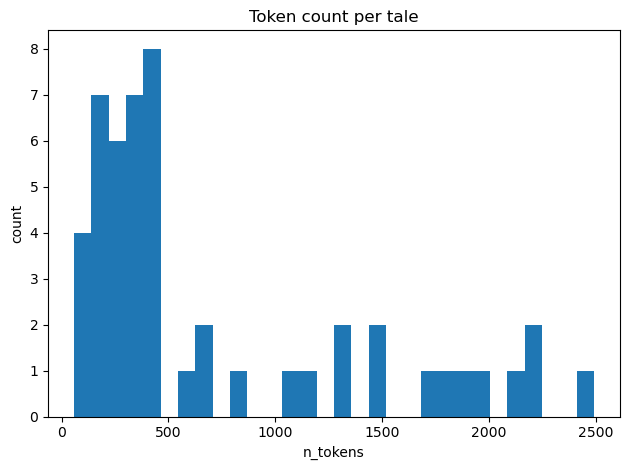

Saved figure: /Users/eugenia/Desktop/thesis/magic_tagger/notebooks/figures/hist_cyr_ratio.png


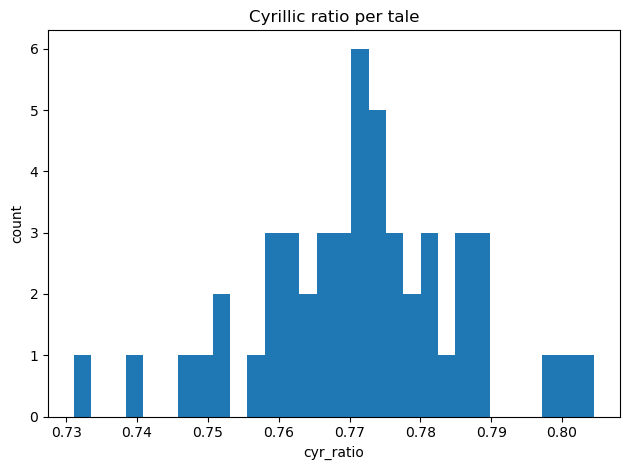

Saved figure: /Users/eugenia/Desktop/thesis/magic_tagger/notebooks/figures/hist_garbage_ratio.png


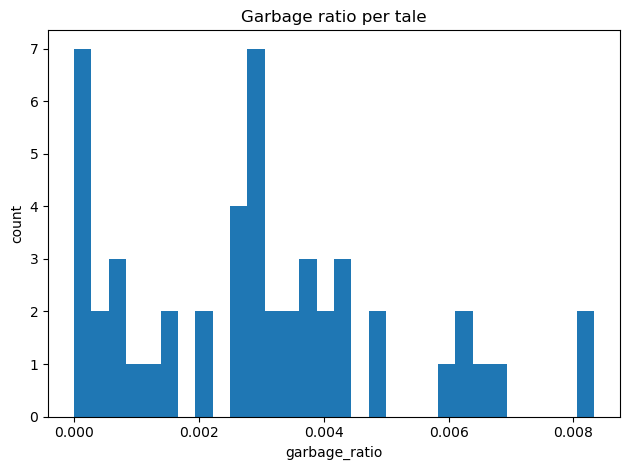

Saved figure: /Users/eugenia/Desktop/thesis/magic_tagger/notebooks/figures/scatter_noise_vs_length.png


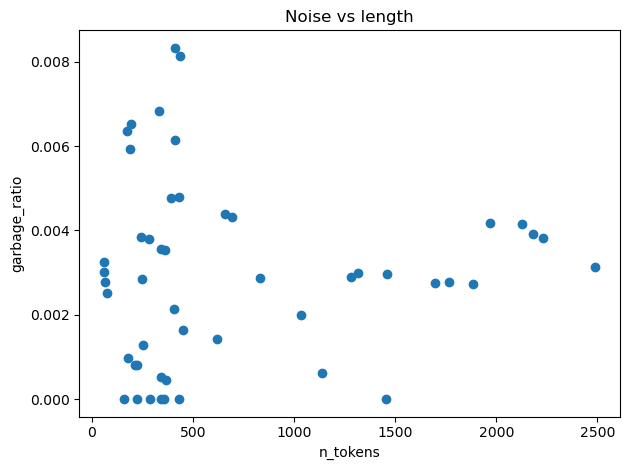

In [35]:
# --- plotting helper ---
def savefig(name: str):
    out = FIG_DIR / name
    plt.tight_layout()
    plt.savefig(out, dpi=200, bbox_inches="tight")
    print("Saved figure:", out)

# 1) Histogram: token count
plt.figure()
plt.hist(dfq["n_tokens"], bins=30)
plt.title("Token count per tale")
plt.xlabel("n_tokens"); plt.ylabel("count")
savefig("hist_n_tokens.png")
plt.show()

# 2) Histogram: Cyrillic ratio
plt.figure()
plt.hist(dfq["cyr_ratio"], bins=30)
plt.title("Cyrillic ratio per tale")
plt.xlabel("cyr_ratio"); plt.ylabel("count")
savefig("hist_cyr_ratio.png")
plt.show()

# 3) Histogram: garbage ratio
plt.figure()
plt.hist(dfq["garbage_ratio"], bins=30)
plt.title("Garbage ratio per tale")
plt.xlabel("garbage_ratio"); plt.ylabel("count")
savefig("hist_garbage_ratio.png")
plt.show()

# 4) Scatter: noise vs length
plt.figure()
plt.scatter(dfq["n_tokens"], dfq["garbage_ratio"])
plt.title("Noise vs length")
plt.xlabel("n_tokens"); plt.ylabel("garbage_ratio")
savefig("scatter_noise_vs_length.png")
plt.show()


## 8. Data Normalization

In [43]:
# whitespace & newlines
RE_WS = re.compile(r"[ \t\f\v]+")
RE_MULTI_NL = re.compile(r"\n{3,}")

# simple hyphenation fix: -\n -> "" (covers dash variants)
RE_HYPHEN_BREAK = re.compile(r"[‐-‒–—-]\s*\n\s*")
RE_REMOVE_BRACKETS_ONLY = re.compile(r"[\[\]]")

# optional: remove page markers (safe for your summary, per your note)
RE_PAGE_MARKERS = re.compile(
    r"(?im)^\s*(page\s*\d+|стр\.?\s*\d+|страниц[аы]?\s*\d+|\d+\s*/\s*\d+)\s*$"
)
RE_LINE_NUM_ONLY = re.compile(r"(?m)^\s*\d{1,3}\.?\s*$")

# garbage symbols (extend if needed)
RE_GARBAGE_CHARS = re.compile(r"[|¬¦¤§¶•★☆◆◇■□▲△▶▷◀◁●◦]", flags=re.UNICODE)

# punctuation spacing
RE_SPACE_BEFORE_PUNCT = re.compile(r"\s+([,.;:!?])")
RE_SPACE_AFTER_PUNCT = re.compile(r"([,.;:!?])([^\s])")

# dash unification
RE_ALL_DASHES = re.compile(r"[‐-‒–—]")


def normalize_text(s: str) -> str:
    if s is None:
        return ""

    # 1) Unicode NFKC
    s = unicodedata.normalize("NFKC", str(s))

    # 2) Normalize line endings
    s = s.replace("\r\n", "\n").replace("\r", "\n")

    # 3) Remove systematic "noise lines" (safe per your summary properties)
    s = RE_PAGE_MARKERS.sub("", s)
    s = RE_LINE_NUM_ONLY.sub("", s)

    # 4) Remove garbage characters
    s = RE_GARBAGE_CHARS.sub("", s)

    # 5) Glue hyphenated line breaks: -\n -> ""
    s = RE_HYPHEN_BREAK.sub("", s)

    # 6) Collapse remaining newlines to spaces
    s = RE_MULTI_NL.sub("\n\n", s)
    s = s.replace("\n", " ")

    # 7) lower + ё→е
    s = s.lower().replace("ё", "е")

    # 8) Unify dashes: long dashes -> '—', in-word '—' -> '-'
    s = RE_ALL_DASHES.sub("—", s)
    s = re.sub(r"(?<=\w)—(?=\w)", "-", s)

    # 9) Whitespace normalization
    s = RE_WS.sub(" ", s).strip()

    # 10) Punctuation spacing
    s = RE_SPACE_BEFORE_PUNCT.sub(r"\1", s)
    s = RE_SPACE_AFTER_PUNCT.sub(r"\1 \2", s)
    s = RE_REMOVE_BRACKETS_ONLY.sub("", s)

    # 11) Final cleanup
    s = RE_WS.sub(" ", s).strip()

    return s

In [44]:
xlsx_path = PROJECT_ROOT / "data" / "processed" / "classify_data_htr_transcrip_clean.xlsx"

df_texts_clean = pd.read_excel(xlsx_path)

print("Shape:", df_texts_clean.shape)
print("\nColumns:")
print(list(df_texts_clean.columns))

display(df_texts_clean.head())


Shape: (50, 12)

Columns:
['tale_id', 'rights_status', 'content_description', 'set', 'sampling_version', 'type_count', 'collection', 'volume_no', 'source_ref', 'atu_labels_json', 'txt_path', 'text_raw']


,tale_id,rights_status,content_description,set,sampling_version,type_count,collection,volume_no,source_ref,atu_labels_json,txt_path,text_raw
0,era_vene_1_503_1,open,[Царевна-лягушка].,core,v1_20251230,3,"ERA, Vene",1,"ERA, Vene 1, 503/4 (1)","[""402""]",/Users/eugenia/Desktop/thesis/magic_tagger/dat...,Тили были царь с царицей у не\nбыло три сына. ...
1,era_vene_1_515_1,open,"[По пьяни мужик спорит, что сможет принести но...",coverage,v1_20251230,1,"ERA, Vene",1,"ERA, Vene 1, 515/6 (1)","[""410""]",/Users/eugenia/Desktop/thesis/magic_tagger/dat...,"Раз пяное, ребятище» подился.\nчто можит в 12 ..."
2,era_vene_12_105_22,open,Снегурочка.,core,v1_20251230,3,"ERA, Vene",12,"ERA, Vene 12, 105 (22)","[""703*""]",/Users/eugenia/Desktop/thesis/magic_tagger/dat...,Сделали дети со снегу куклу.\nВ одного старина...
3,era_vene_12_137_98,open,Иван-дурак.,core,v1_20251230,4,"ERA, Vene",12,"ERA, Vene 12, 137/41 (98)","[""530""]",/Users/eugenia/Desktop/thesis/magic_tagger/dat...,"Кил-был стажк. В яво бло\nтра сегна. Миша, Гри..."
4,era_vene_12_189_1,open,Два брата.,core,v1_20251230,2,"ERA, Vene",12,"ERA, Vene 12, 189/94 (1)","[""735A""]",/Users/eugenia/Desktop/thesis/magic_tagger/dat...,Жили – брели два брата.\nи посла смерти отца о...


In [46]:
df_texts_clean = df_texts_clean.copy()

# content_description -> summary_norm
if "content_description" in df_texts_clean.columns:
    df_texts_clean["summary_norm"] = (
        df_texts_clean["content_description"]
        .fillna("")
        .astype(str)
        .apply(normalize_text)
    )

# text_raw -> text_norm
if "text_raw" in df_texts_clean.columns:
    df_texts_clean["text_norm"] = (
        df_texts_clean["text_raw"]
        .fillna("")
        .astype(str)
        .apply(normalize_text)
    )

display(df_texts_clean[["tale_id", "summary_norm", "text_norm"]].head(30))

,tale_id,summary_norm,text_norm
0,era_vene_1_503_1,царевна-лягушка.,тили были царь с царицей у не было три сына. ц...
1,era_vene_1_515_1,"по пьяни мужик спорит, что сможет принести ноч...","раз пяное, ребятище» подился. что можит в 12 ч..."
2,era_vene_12_105_22,снегурочка.,сделали дети со снегу куклу. в одного старина ...
3,era_vene_12_137_98,иван-дурак.,"кил-был стажк. в яво бло тра сегна. миша, гриш..."
4,era_vene_12_189_1,два брата.,жили — брели два брата. и посла смерти отца об...
5,era_vene_12_440_19,снегурочка.,вили дед да бада и стали ен замой со снегу дев...
6,era_vene_12_501_1,морозко.,дрил мужем да баба было в и двя дочери. една б...
7,era_vene_12_541_1,липунюшка мальчик-с-пальчик.,"жбре старии да старуха, не брело в их дятей. п..."
8,era_vene_12_592_4,снегурочка.,жия музик да баба стара люди были. не брело в ...
9,era_vene_12_95_18,мальчик-с-пальчик. мужик бросает отрубленный п...,"бубил мужик дрова и отру был сей пальчила, бро..."


In [47]:
df_texts_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   tale_id              50 non-null     object
 1   rights_status        50 non-null     object
 2   content_description  50 non-null     object
 3   set                  50 non-null     object
 4   sampling_version     50 non-null     object
 5   type_count           50 non-null     int64 
 6   collection           50 non-null     object
 7   volume_no            50 non-null     int64 
 8   source_ref           50 non-null     object
 9   atu_labels_json      50 non-null     object
 10  txt_path             44 non-null     object
 11  text_raw             50 non-null     object
 12  summary_norm         50 non-null     object
 13  text_norm            50 non-null     object
dtypes: int64(2), object(12)
memory usage: 5.6+ KB


In [49]:
out_csv = PROJECT_ROOT / "data" / "processed" / "classify_data_normalized.csv"
df_texts_clean.to_csv(out_csv, index=False, encoding="utf-8")
print("Saved:", out_csv)

Saved: /Users/eugenia/Desktop/thesis/magic_tagger/data/processed/classify_data_normalized.csv
